In [1]:
# Importations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from histo_starterkit.constants import DF_TRAIN_PATH, DF_TEST_PATH, WEIGHTS_PATH
from histo_starterkit.utils import fit, save_model, save_pickle
from histo_starterkit.utils import get_loss, plot_logs_tts
from histo_starterkit.datasets import SlideFeaturesDataset

from histo_starterkit.models import MeanPool, MaxPool, CustomDeepMIL
from classic_algos.nn import Chowder, DeepMIL, MultiHeadDeepMIL

In [2]:
# Define parameters
params = {
    # General params
    'random_state':42,
    'device':'cuda',
    
    # Dataset params
    'max_tiles':10_000,
    
    # Model params
    'model_name':'MeanPool',
    'loss_name':'BCEWithLogitsLoss',
    
    # Training params
    'batch_size':32,
    'num_epochs':20,
    'learning_rate':1e-3,
    
    # Validation params
    ## Train/valid split
    'valid_size':0.20,
    ## Cross-validation
    'n_repeats':3,
    'n_splits':5,
}

In [48]:
max_tiles = 10_000

features = np.load('/STORAGE/data/Camelyon_clean/tiles_0.5mpp/Normal_003.npy')
mask = np.zeros((max_tiles, 1))
print(features.shape, mask.shape)
if len(features) < max_tiles:
    mask[len(features):][:] = np.ones((max_tiles-len(features), 1))
    features = np.pad(features, ((0, max_tiles-len(features)), (0, 0)), 'constant', constant_values=0)
print(features.shape, mask.shape)

(5024, 2051) (10000, 1)
(10000, 2051) (10000, 1)


In [4]:
# Train/valid split

# Load data
df_train = pd.read_csv(DF_TRAIN_PATH)
df_valid = pd.read_csv(DF_TEST_PATH)

# Train/valid split
#df_train, df_valid = train_test_split(df, test_size=params['valid_size'], random_state=params['random_state'])

print('Train set:', len(df_train))
print('Valid set:', len(df_valid))

# Datasets
train_dataset = SlideFeaturesDataset(df_train, max_tiles=params['max_tiles'])
valid_dataset = SlideFeaturesDataset(df_valid, max_tiles=params['max_tiles'])

# Dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset, 
    shuffle=True, 
    batch_size=params['batch_size'],
    drop_last=True,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    shuffle=False, 
    batch_size=params['batch_size'],
)

Train set: 269
Valid set: 130


In [5]:
batch = iter(valid_dataloader).next()
features, masks, labels = batch
features = features.to(params['device'])
masks = masks.to(params['device'])
labels = labels.to(params['device'])
print(features.shape, masks.shape, labels.shape)

torch.Size([32, 15000, 2048]) torch.Size([32, 15000, 1]) torch.Size([32, 1])


In [8]:
# Define model, loss, optimizer
#model = DeepMIL.classification(in_features=2048, out_features=1).to(params['device'])
#model = Chowder.classification(in_features=2048, out_features=1).to(params['device'])
#model = MultiHeadDeepMIL.classification(in_features=2048, out_features=1).to(params['device'])
#model = MeanPool(in_features=2048, out_features=1).to(params['device'])
#model = MaxPool(in_features=2048, out_features=1).to(params['device'])
model = CustomDeepMIL(in_features=2048, out_features=1).to(params['device'])
criterion = get_loss(params['loss_name']).to(params['device'])

In [9]:
outputs, scores = model(features, masks)
loss = criterion(outputs, labels)
print(outputs.shape, loss)

torch.Size([32, 1]) tensor(0.7017, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


Train set: 269
Valid set: 130


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch: 1
Train loss: 0.68700546 ; Valid loss: 0.65089035
Train metric: 0.5214128035320088 ; Valid metric: 0.4335


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch: 2
Train loss: 0.6501323 ; Valid loss: 0.6429082
Train metric: 0.6462550607287448 ; Valid metric: 0.45775


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch: 3
Train loss: 0.61052704 ; Valid loss: 0.6273845
Train metric: 0.7469567959634185 ; Valid metric: 0.51275


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch: 4
Train loss: 0.55291206 ; Valid loss: 0.62229633
Train metric: 0.7940915991902834 ; Valid metric: 0.5790000000000001


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch: 5
Train loss: 0.49689186 ; Valid loss: 0.5680209
Train metric: 0.8324187953327027 ; Valid metric: 0.635


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch: 6
Train loss: 0.44181633 ; Valid loss: 0.55835783
Train metric: 0.8559444970040997 ; Valid metric: 0.6557499999999999


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch: 7
Train loss: 0.431579 ; Valid loss: 0.5567726
Train metric: 0.8596026490066224 ; Valid metric: 0.67425


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch: 8
Train loss: 0.42239785 ; Valid loss: 0.5577857
Train metric: 0.8560706401766005 ; Valid metric: 0.6702500000000001


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch: 9
Train loss: 0.3747297 ; Valid loss: 0.56378114
Train metric: 0.8956857287449393 ; Valid metric: 0.66375


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch: 10
Train loss: 0.35824135 ; Valid loss: 0.54820454
Train metric: 0.9037527593818985 ; Valid metric: 0.6747500000000001


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch: 11
Train loss: 0.33496302 ; Valid loss: 0.5409028
Train metric: 0.9131652661064426 ; Valid metric: 0.68325


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch: 12
Train loss: 0.33434302 ; Valid loss: 0.5425629
Train metric: 0.9221721721721721 ; Valid metric: 0.69975


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch: 13
Train loss: 0.324238 ; Valid loss: 0.54151976
Train metric: 0.9234310942920215 ; Valid metric: 0.6942499999999999


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch: 14
Train loss: 0.30737394 ; Valid loss: 0.5662564
Train metric: 0.930242825607064 ; Valid metric: 0.7


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch: 15
Train loss: 0.3040261 ; Valid loss: 0.55916464
Train metric: 0.9356856856856857 ; Valid metric: 0.68475


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch: 16
Train loss: 0.28566557 ; Valid loss: 0.5738415
Train metric: 0.9407957357700362 ; Valid metric: 0.69075


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch: 17
Train loss: 0.26609427 ; Valid loss: 0.572647
Train metric: 0.9522641509433962 ; Valid metric: 0.6900000000000001


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch: 18
Train loss: 0.2563445 ; Valid loss: 0.5964271
Train metric: 0.9549056603773585 ; Valid metric: 0.694


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch: 19
Train loss: 0.23659302 ; Valid loss: 0.5990012
Train metric: 0.9631031220435193 ; Valid metric: 0.68825


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch: 20
Train loss: 0.2286854 ; Valid loss: 0.6150706
Train metric: 0.9649952696310312 ; Valid metric: 0.6917499999999999


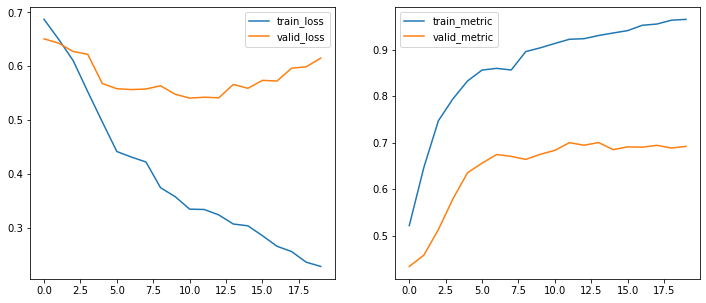

In [9]:
# Train/valid split

# Load data
df_train = pd.read_csv(DF_TRAIN_PATH)
df_valid = pd.read_csv(DF_TEST_PATH)

# Train/valid split
#df_train, df_valid = train_test_split(df, test_size=params['valid_size'], random_state=params['random_state'])

print('Train set:', len(df_train))
print('Valid set:', len(df_valid))

# Datasets
train_dataset = SlideFeaturesDataset(df_train, max_tiles=params['max_tiles'])
valid_dataset = SlideFeaturesDataset(df_valid, max_tiles=params['max_tiles'])

# Dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset, 
    shuffle=True, 
    batch_size=params['batch_size'],
    drop_last=True,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    shuffle=False, 
    batch_size=params['batch_size'],
)

# Define model, loss, optimizer
#model = get_model(params['model_name']).to(params['device'])
model = CustomDeepMIL(in_features=2048, out_features=1).to(params['device'])
criterion = get_loss(params['loss_name']).to(params['device'])
optimizer = Adam(model.parameters(), lr=params['learning_rate'])

# Training
train_losses, valid_losses, train_metrics, valid_metrics = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=params['num_epochs'],
    device=params['device'],
    verbose=True,
)

plot_logs_tts(train_losses, valid_losses, train_metrics, valid_metrics)

In [ ]:
#save_model(os.path.join(WEIGHTS_PATH, 'tmp.pth'), model)
#save_pickle(os.path.join(WEIGHTS_PATH, 'tmp.pkl'), params)

REPEAT: 0 ; SPLIT: 0
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7099939 ; Valid loss: 0.66033345
Train metric: 0.5208674698795182 ; Valid metric: 0.5347222222222222
Epoch: 2
Train loss: 0.6714665 ; Valid loss: 0.65379
Train metric: 0.5307951807228916 ; Valid metric: 0.5444444444444445


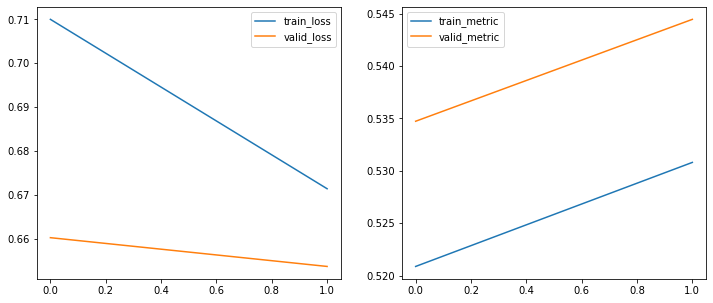

REPEAT: 0 ; SPLIT: 1
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7209659 ; Valid loss: 0.6944498
Train metric: 0.49586857198405754 ; Valid metric: 0.426367461430575
Epoch: 2
Train loss: 0.6830568 ; Valid loss: 0.6714455
Train metric: 0.5124820659971305 ; Valid metric: 0.4488078541374474


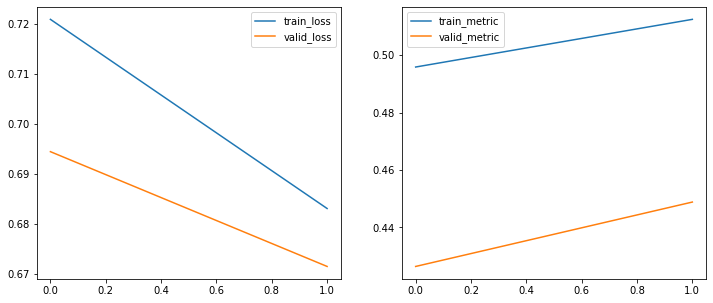

REPEAT: 0 ; SPLIT: 2
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.70379215 ; Valid loss: 0.6818212
Train metric: 0.4549019607843137 ; Valid metric: 0.4796633941093969
Epoch: 2
Train loss: 0.68397325 ; Valid loss: 0.66487074
Train metric: 0.4834159359512009 ; Valid metric: 0.49789621318373073


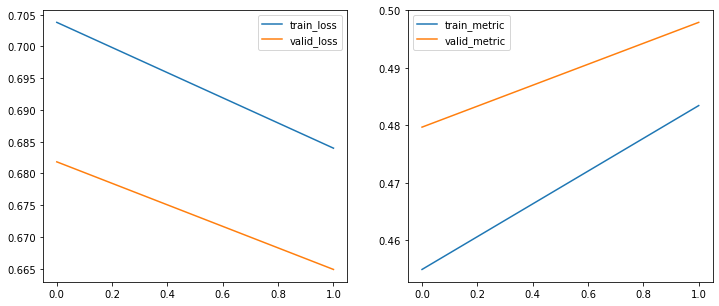

REPEAT: 0 ; SPLIT: 3
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.6668304 ; Valid loss: 0.65264297
Train metric: 0.5566248663361525 ; Valid metric: 0.5652173913043478
Epoch: 2
Train loss: 0.67642474 ; Valid loss: 0.6529535
Train metric: 0.5464163171940526 ; Valid metric: 0.6002805049088359


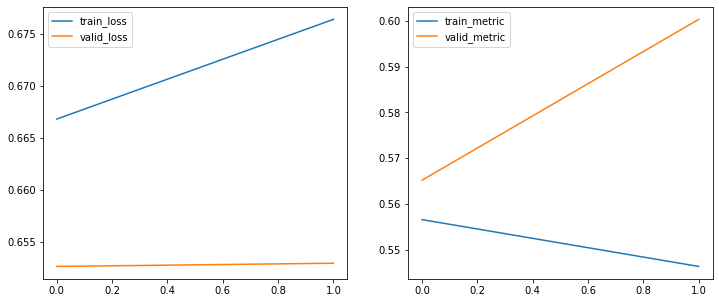

REPEAT: 0 ; SPLIT: 4
Train set: 216
Valid set: 53
Epoch: 1
Train loss: 0.6867399 ; Valid loss: 0.6482525
Train metric: 0.5483234714003945 ; Valid metric: 0.5375816993464052
Epoch: 2
Train loss: 0.6799259 ; Valid loss: 0.61354375
Train metric: 0.5498064394297045 ; Valid metric: 0.5637254901960784


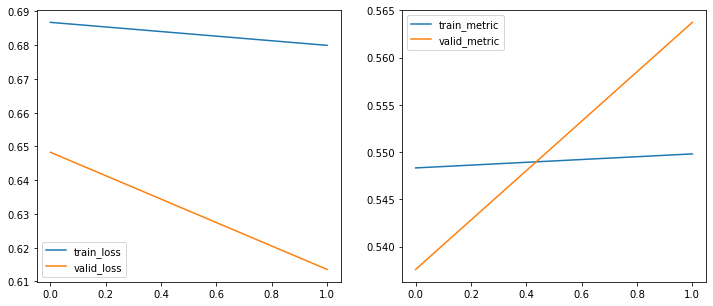

REPEAT: 1 ; SPLIT: 0
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7050504 ; Valid loss: 0.67544
Train metric: 0.5347469879518072 ; Valid metric: 0.5158620689655173
Epoch: 2
Train loss: 0.6799218 ; Valid loss: 0.668192
Train metric: 0.5086140147115756 ; Valid metric: 0.52


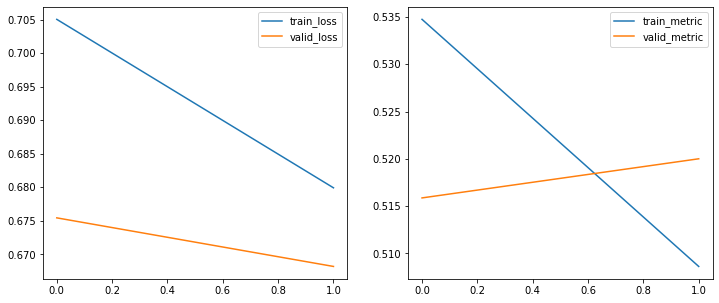

REPEAT: 1 ; SPLIT: 1
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.6886591 ; Valid loss: 0.64549434
Train metric: 0.4771780303030303 ; Valid metric: 0.41654135338345866
Epoch: 2
Train loss: 0.6833731 ; Valid loss: 0.6402341
Train metric: 0.5166666666666667 ; Valid metric: 0.4406015037593985


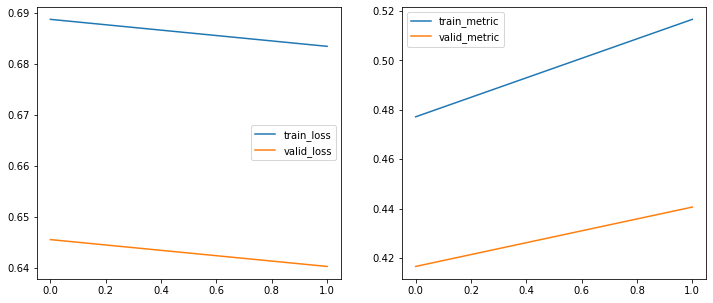

REPEAT: 1 ; SPLIT: 2
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7318609 ; Valid loss: 0.6736168
Train metric: 0.4550189393939393 ; Valid metric: 0.473529411764706
Epoch: 2
Train loss: 0.68755937 ; Valid loss: 0.64113915
Train metric: 0.49539279946803455 ; Valid metric: 0.46764705882352947


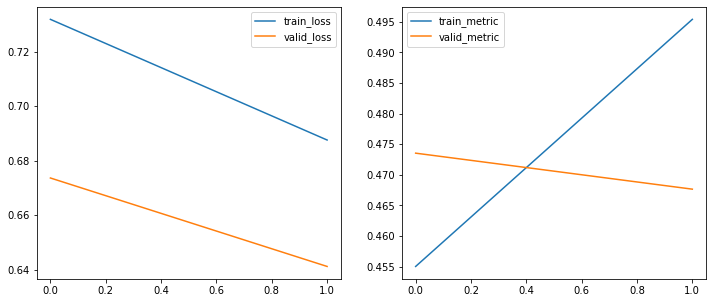

REPEAT: 1 ; SPLIT: 3
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.6865885 ; Valid loss: 0.67566997
Train metric: 0.4989000478240077 ; Valid metric: 0.39831697054698456
Epoch: 2
Train loss: 0.6777427 ; Valid loss: 0.6730722
Train metric: 0.5246293639406983 ; Valid metric: 0.40813464235624125


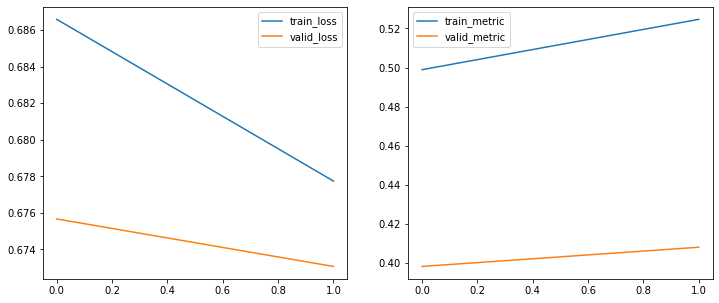

REPEAT: 1 ; SPLIT: 4
Train set: 216
Valid set: 53
Epoch: 1
Train loss: 0.66901296 ; Valid loss: 0.6539144
Train metric: 0.555566265060241 ; Valid metric: 0.5594202898550724
Epoch: 2
Train loss: 0.6726694 ; Valid loss: 0.64887697
Train metric: 0.565375418460067 ; Valid metric: 0.5695652173913043


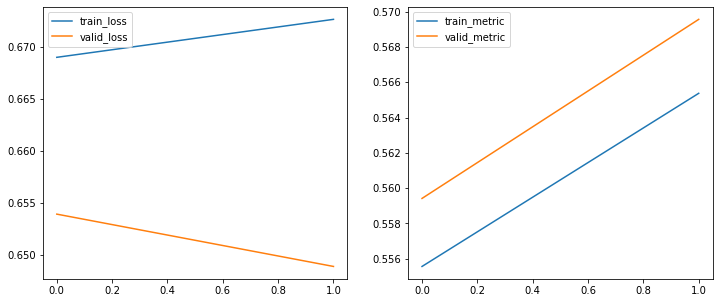

REPEAT: 2 ; SPLIT: 0
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7430015 ; Valid loss: 0.67544675
Train metric: 0.5044507575757575 ; Valid metric: 0.6015037593984962
Epoch: 2
Train loss: 0.7059351 ; Valid loss: 0.6152108
Train metric: 0.44566141063166836 ; Valid metric: 0.6285714285714287


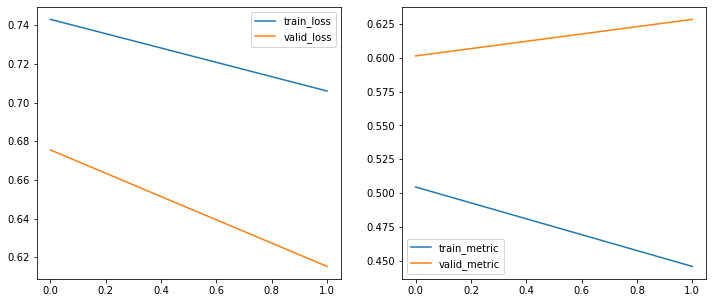

REPEAT: 2 ; SPLIT: 1
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7010745 ; Valid loss: 0.68351144
Train metric: 0.41667469879518076 ; Valid metric: 0.4768583450210379
Epoch: 2
Train loss: 0.6835732 ; Valid loss: 0.66710764
Train metric: 0.44483159117305465 ; Valid metric: 0.4768583450210379


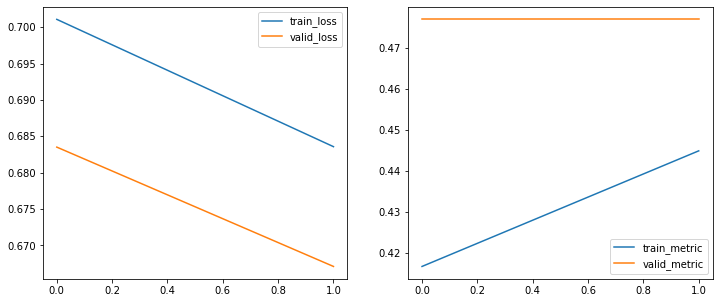

REPEAT: 2 ; SPLIT: 2
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.6790605 ; Valid loss: 0.68157583
Train metric: 0.45078991266804047 ; Valid metric: 0.4876373626373626
Epoch: 2
Train loss: 0.6827491 ; Valid loss: 0.67525005
Train metric: 0.4640963855421687 ; Valid metric: 0.49175824175824173


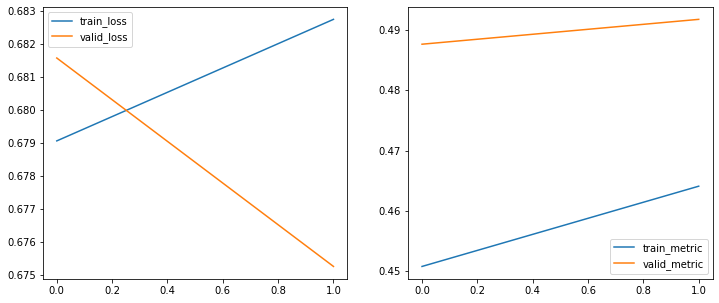

REPEAT: 2 ; SPLIT: 3
Train set: 215
Valid set: 54
Epoch: 1
Train loss: 0.7707671 ; Valid loss: 0.7272066
Train metric: 0.4415719696969697 ; Valid metric: 0.39105339105339104
Epoch: 2
Train loss: 0.6788917 ; Valid loss: 0.66354823
Train metric: 0.5494939759036145 ; Valid metric: 0.41414141414141414


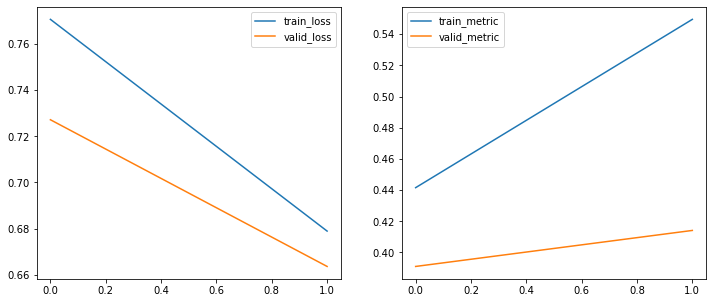

REPEAT: 2 ; SPLIT: 4
Train set: 216
Valid set: 53
Epoch: 1
Train loss: 0.69735014 ; Valid loss: 0.641181
Train metric: 0.4274326820258579 ; Valid metric: 0.5639880952380952
Epoch: 2
Train loss: 0.68503284 ; Valid loss: 0.63674235
Train metric: 0.4867424242424242 ; Valid metric: 0.5773809523809523


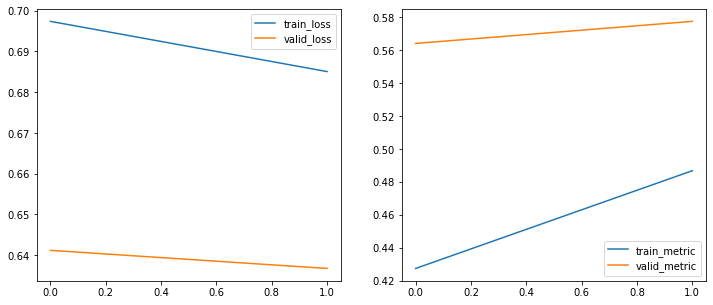

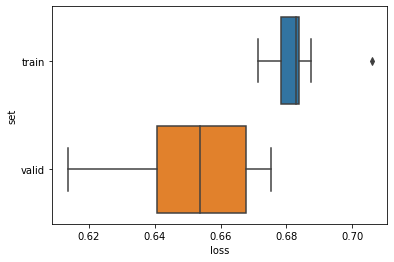

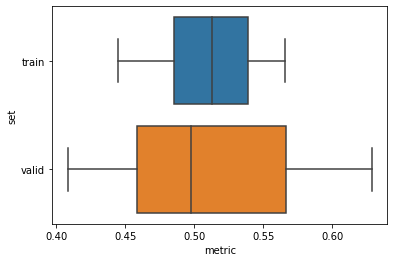

In [6]:
# Cross-validation

# Load data
df = pd.read_csv(DF_TRAIN_PATH)

cv_train_loss, cv_val_loss = [], []
cv_train_metric, cv_val_metric = [], []
for r in range(params['n_repeats']):
    kf = KFold(n_splits=params['n_splits'], shuffle=True)
    for k, (train_indices, valid_indices) in enumerate(kf.split(df)):
        print('REPEAT:', r, '; SPLIT:', k)

        df_train, df_valid = df.iloc[train_indices], df.iloc[valid_indices]

        print('Train set:', len(df_train))
        print('Valid set:', len(df_valid))

        # Datasets
        train_dataset = SlideFeaturesDataset(df_train, max_tiles=params['max_tiles'])
        valid_dataset = SlideFeaturesDataset(df_valid, max_tiles=params['max_tiles'])

        # Dataloaders
        train_dataloader = DataLoader(
            dataset=train_dataset, 
            shuffle=True, 
            batch_size=params['batch_size'],
            drop_last=True,
        )
        valid_dataloader = DataLoader(
            dataset=valid_dataset, 
            shuffle=False, 
            batch_size=params['batch_size'],
        )

        # Define model, loss, optimizer
        model = get_model(params['model_name']).to(params['device'])
        criterion = get_loss(params['loss_name']).to(params['device'])
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])

        # Training
        model, train_losses, valid_losses, train_metrics, valid_metrics = fit(
            model=model,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=params['num_epochs'],
            device=params['device'],
            verbose=False,
        )

        #plot_logs(train_losses, valid_loss, train_metrics, valid_metrics)
        print(train_losses[-1], valid_losses[-1])
        print(train_metrics[-1], valid_metrics[-1])
        
        cv_train_loss.append(train_losses[-1]); cv_val_loss.append(valid_losses[-1])
        cv_train_metric.append(train_metrics[-1]); cv_val_metric.append(valid_metrics[-1])
        
cv_df = pd.DataFrame(data={
    'loss': cv_train_loss+cv_val_loss, 
    'metric': cv_train_metric+cv_val_metric,
    'set':['train']*len(cv_train_loss)+['valid']*len(cv_val_loss),
})

sns.boxplot(x='loss', y='set', data=cv_df); plt.show()
sns.boxplot(x='metric', y='set', data=cv_df); plt.show()

In [9]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score

from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

from classic_algos.nn import Chowder, DeepMIL
from histo_starterkit.models import MeanPool, MaxPool

from histo_starterkit.constants import DF_TEST_PATH, WEIGHTS_PATH
from histo_starterkit.utils import eval_step, load_pickle

In [10]:
params = load_pickle(os.path.join(WEIGHTS_PATH, 'tmp.pkl'))

In [11]:
# Load data
df_test = pd.read_csv(DF_TEST_PATH)

print('Test set:', len(df_test))

# Datasets
test_dataset = SlideFeaturesDataset(df_test, max_tiles=params['max_tiles'])

# Dataloaders
test_dataloader = DataLoader(
    dataset=test_dataset, 
    shuffle=False, 
    batch_size=params['batch_size'],
)

Test set: 130


In [12]:
df_test = pd.read_csv(DF_TEST_PATH)
test_dataset = SlideFeaturesDataset(df_test, max_tiles=params['max_tiles'])
test_dataloader = DataLoader(
    dataset=test_dataset, 
    shuffle=False, 
    batch_size=params['batch_size'],
)

In [13]:
model = get_model(params['model_name']).to(params['device'])
model.load_state_dict(torch.load(os.path.join(WEIGHTS_PATH, 'tmp.pth')))
criterion = get_loss(params['loss_name']).to(params['device'])

In [14]:
test_losses, test_preds, test_labels = eval_step(model, test_dataloader, criterion, params['device'])

test_loss = np.mean(test_losses)
test_metric = roc_auc_score(test_labels, test_preds)

In [15]:
test_loss, test_metric

(0.6538943, 0.54675)